In [12]:
from PIL import Image
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

def extract_puzzle_piece(image_path: str, show: bool = False) -> Image.Image:
    """
    Extrahiert ein Puzzleteil aus einem RGB-Bild, entfernt den Hintergrund
    und gibt ein RGBA-Bild mit transparenter Maske zurück.
    """
    # Bild laden
    image = Image.open(image_path).convert("RGB")
    rgb = np.array(image)
    
    # Graustufen & Kanten
    gray = image.convert("L")
    gray_np = np.array(gray, dtype=np.float32)
    dx = ndimage.sobel(gray_np, axis=0)
    dy = ndimage.sobel(gray_np, axis=1)
    edges = np.hypot(dx, dy)

    # Adaptive Schwelle
    threshold = np.mean(edges) + np.std(edges)
    binary_edges = edges > threshold

    # Maske aufbauen (Kanten -> Fläche)
    binary_filled = ndimage.binary_closing(binary_edges, structure=np.ones((3, 3)), iterations=2)
    labeled, _ = ndimage.label(binary_filled)
    sizes = ndimage.sum(binary_filled, labeled, range(1, labeled.max() + 1))
    largest_label = np.argmax(sizes) + 1
    mask = labeled == largest_label

    # RGB auf Schwarz setzen, wo Maske False ist
    rgb_masked = rgb.copy()
    rgb_masked[~mask] = [0, 0, 0]
    alpha = (mask * 255).astype(np.uint8)

    # RGBA erzeugen
    rgba = np.dstack((rgb_masked, alpha))

    # Bounding Box anwenden
    coords = np.argwhere(mask)
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1
    cropped_rgba = rgba[y0:y1, x0:x1]
    result_image = Image.fromarray(cropped_rgba)

    # Optional anzeigen
    if show:
        plt.figure(figsize=(6, 6))
        plt.imshow(result_image)
        plt.title("Extrahiertes Puzzleteil")
        plt.axis("off")
        plt.show()
    
    return result_image


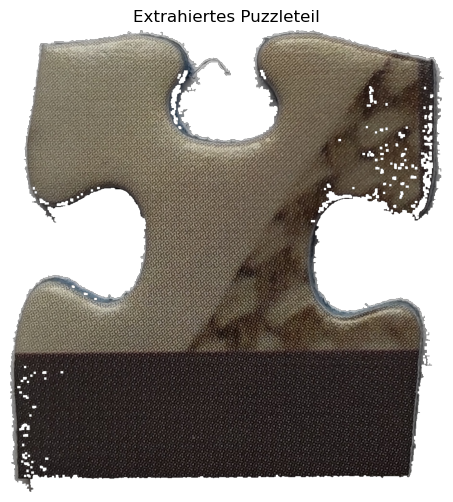

In [14]:
img = extract_puzzle_piece("data/pzl_1/pzl_1_001_front.jpg", show=True)
# Optional speichern:
img.save("puzzle_clean.png")


In [16]:
from PIL import Image
import numpy as np
from scipy.signal import correlate2d
import matplotlib.pyplot as plt

def match_puzzle_piece_on_board(board_path: str, piece_image: Image.Image):
    """
    Versucht das Puzzleteil auf dem vollständigen Puzzlebild zu matchen,
    indem es über alle Positionen gleitet und per Korrelation die beste Übereinstimmung findet.
    """

    # Vollständiges Puzzlebild laden (RGB)
    board = Image.open(board_path).convert("RGB")
    board_np = np.array(board)

    # Puzzleteil vorbereiten (RGBA)
    piece_rgba = np.array(piece_image)
    piece_rgb = piece_rgba[:, :, :3]
    piece_alpha = piece_rgba[:, :, 3] > 0  # Maske

    h_board, w_board, _ = board_np.shape
    h_piece, w_piece, _ = piece_rgb.shape

    assert h_piece <= h_board and w_piece <= w_board, "Puzzleteil ist grösser als das Puzzleboard!"

    # Maske als Gewicht
    piece_mask = piece_alpha.astype(np.float32)

    # Leere Korrelaionskarte
    correlation_map = np.zeros((h_board - h_piece + 1, w_board - w_piece + 1))

    # Pro Farbkanal (R, G, B)
    for c in range(3):
        board_channel = board_np[:, :, c].astype(np.float32)
        piece_channel = piece_rgb[:, :, c].astype(np.float32) * piece_mask
        corr = correlate2d(board_channel, piece_channel, mode="valid")
        correlation_map += corr

    # Beste Position
    best_y, best_x = np.unravel_index(np.argmax(correlation_map), correlation_map.shape)

    # Overlay erzeugen
    result_image = board_np.copy()
    mask_expanded = piece_alpha[:, :, None]
    result_image[best_y:best_y + h_piece, best_x:best_x + w_piece] = (
        result_image[best_y:best_y + h_piece, best_x:best_x + w_piece] * (~mask_expanded) +
        piece_rgb * mask_expanded
    )

    # Anzeigen
    plt.figure(figsize=(10, 10))
    plt.imshow(result_image)
    plt.title(f"Puzzleteil eingefügt bei (x={best_x}, y={best_y})")
    plt.axis("off")
    plt.show()

    return best_x, best_y


In [ ]:
puzzle_piece = extract_puzzle_piece("data/pzl_1/pzl_1_001_front.jpg")  # oder dein Bild
match_puzzle_piece_on_board("data/pzl_1/pzl_1_full_front.jpg", puzzle_piece)


FileNotFoundError: [Errno 2] No such file or directory: 'data/plz_1/plz_1_full_front.jpg'